# Capstone Project: Fraud Payment Detection - Low Amount

## 1. Overview

This publication includes or references synthetic data provided by J.P. Morgan. It describes payment information of 1,495,782 observations. The dataset contains transactional information including payment amount, senders and receivers of a large variety of payment transaction types enriched with labels representing legitimate or fraudulent payments.

## 2. Data Loading

Use pandas to read in the dataset and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, LearningCurveDisplay, learning_curve
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, make_scorer, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance
from sklearn import tree
from sklearn.tree import plot_tree
import graphviz
import dataframe_image as dfi
from scipy.stats import loguniform
from matplotlib.gridspec import GridSpec
import time

pd.options.mode.chained_assignment = None  
import warnings
warnings.filterwarnings("ignore")

In [2]:
payment = pd.read_csv('data/fraud_payment_data.csv')
df_eda = payment

## 3. Data Cleaning

In [3]:
#Extract prefixes of categorical columns
df_eda[['Transaction_Cat', 'Transaction_No']] = df_eda.Transaction_Id.str.rsplit('-', n=1, expand = True)
df_eda[['Sender_Id', 'Bene_Id']] = df_eda[['Sender_Id', 'Bene_Id']].fillna(value = 'unknown-0')
df_eda[['Sender_Cat', 'Sender_No']] = df_eda.Sender_Id.str.rsplit('-', n=1, expand = True)
df_eda[['Bene_Cat', 'Bene_No']] = df_eda.Bene_Id.str.rsplit('-', n=1, expand = True)
pd.options.display.max_columns = None
df_eda.head(3)

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Transaction_Cat,Transaction_No,Sender_Cat,Sender_No,Bene_Cat,Bene_No
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,unknown-0,NaN,NaN,558.43,0,WITHDRAWAL,EXCHANGE,10115,JPMC-CLIENT,10098,unknown,0
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,QUICK-PAYMENT,10116,JPMC-CLIENT,10098,CLIENT,10100
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,unknown-0,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,DEPOSIT-CASH,9833,unknown,0,JPMC-CLIENT,9812


In [4]:
#Drop less valued columns 
df_clean = df_eda.drop(['Transaction_Id', 'Transaction_Type','Transaction_No',
                        'Sender_lob', 'Sender_Sector', 'Time_step',
                        'Bene_Id', 'Sender_Id', 'Sender_No', 'Bene_No'
                       ], axis = 1)

#Replace "USA" with "UNITED-STATES" for consistency
df_clean[['Sender_Country','Bene_Country']] = df_clean[['Sender_Country','Bene_Country']].replace('USA', 'UNITED-STATES')

df_clean.head(3)

,Sender_Account,Sender_Country,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Cat,Sender_Cat,Bene_Cat
0,ACCOUNT-10108,UNITED-STATES,NaN,NaN,558.43,0,EXCHANGE,JPMC-CLIENT,unknown
1,ACCOUNT-10109,UNITED-STATES,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,JPMC-CLIENT,CLIENT
2,NaN,NaN,ACCOUNT-9826,UNITED-STATES,802.54,0,DEPOSIT-CASH,unknown,JPMC-CLIENT


#### Drop duplicates and zero amount observations

In [5]:
#Drop rows witn zero amount
df_clean = df_clean[df_clean['USD_amount']>0]
df_clean[df_clean['USD_amount']==0]

,Sender_Account,Sender_Country,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Cat,Sender_Cat,Bene_Cat


In [6]:
#Check duplicates
df_clean.duplicated().sum()

2356

In [7]:
#Drop duplicates
df_clean.drop_duplicates(inplace=True)
df_clean.duplicated().sum()

0

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1495799 entries, 0 to 1498176
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Sender_Account   1276946 non-null  object 
 1   Sender_Country   1276946 non-null  object 
 2   Bene_Account     1279946 non-null  object 
 3   Bene_Country     1279946 non-null  object 
 4   USD_amount       1495799 non-null  float64
 5   Label            1495799 non-null  int64  
 6   Transaction_Cat  1495799 non-null  object 
 7   Sender_Cat       1495799 non-null  object 
 8   Bene_Cat         1495799 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 114.1+ MB


#### Split the dataset into High Amount and Low Amount dataset

In [9]:
#Use the upper fence as the threshold
df_high = df_clean[df_clean['USD_amount'] >=1000]
df_low = df_clean[df_clean['USD_amount'] <1000]
df = df_low

## 4. Feature Engineering

In [10]:
norminal_features = ['Transaction_Cat', 'Sender_Cat', 'Bene_Cat']
high_cardinality_norminal_features = ['Sender_Country','Bene_Country', 'Sender_Account','Bene_Account']
numeric_features = ['USD_amount']

In [11]:
norminal_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value='unknown'),OneHotEncoder())      
high_cardinality_norminal_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value='unknown'),
                                               TargetEncoder(target_type = 'binary'))

In [12]:
col_transformer = ColumnTransformer(
    transformers=[
        ("norminal", norminal_pipe, norminal_features),
        ("high_cardinal", high_cardinality_norminal_pipe, high_cardinality_norminal_features),
        #("num", SimpleImputer(strategy="constant", fill_value=0), numeric_features)
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [13]:
features_trans = col_transformer.fit_transform(df,df['Label'])
#.toarray()
features_names_trans = col_transformer.get_feature_names_out()
df_trans = pd.DataFrame(features_trans, columns = features_names_trans)

In [14]:
#Move "UDS_amount" to the first column
first_column = df_trans.pop('USD_amount')
df_trans.insert(0, 'USD_amount', first_column)
df_trans.head(3)

,USD_amount,Transaction_Cat_CASH-CHECK,Transaction_Cat_DEPOSIT-CASH,Transaction_Cat_DEPOSIT-CHECK,Transaction_Cat_EXCHANGE,Transaction_Cat_MAKE-PAYMENT,Transaction_Cat_MOVE-FUNDS,Transaction_Cat_PAY-BILL,Transaction_Cat_PAY-CHECK,Transaction_Cat_PAYMENT,Transaction_Cat_QUICK-DEPOSIT,Transaction_Cat_QUICK-PAYMENT,Transaction_Cat_WITHDRAWAL,Sender_Cat_BILL-COMPANY,Sender_Cat_CLIENT,Sender_Cat_COMPANY,Sender_Cat_JPMC-CLIENT,Sender_Cat_JPMC-COMPANY,Sender_Cat_unknown,Bene_Cat_BILL-COMPANY,Bene_Cat_CLIENT,Bene_Cat_COMPANY,Bene_Cat_JPMC-CLIENT,Bene_Cat_JPMC-COMPANY,Bene_Cat_unknown,Sender_Country,Bene_Country,Sender_Account,Bene_Account,Label
0,558.43,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.020914,0.022994,0.000000,0.022994,0.0
1,622.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.020887,0.011453,0.000000,0.000000,0.0
2,802.54,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.017164,0.022062,0.017164,0.072148,0.0


### Colleration Matrix

**Observations:**  There is no feature that is strongly correlated to the target variable

In [15]:
corr = round(df_trans.corr(),1)
corr['Label'].abs().nlargest(6)

Label                         1.0
Transaction_Cat_PAYMENT       0.1
Sender_Account                0.1
Bene_Account                  0.1
USD_amount                    0.0
Transaction_Cat_CASH-CHECK    0.0
Name: Label, dtype: float64

In [16]:
selected_feature_names_corr = corr['Label'].abs().nlargest(6)

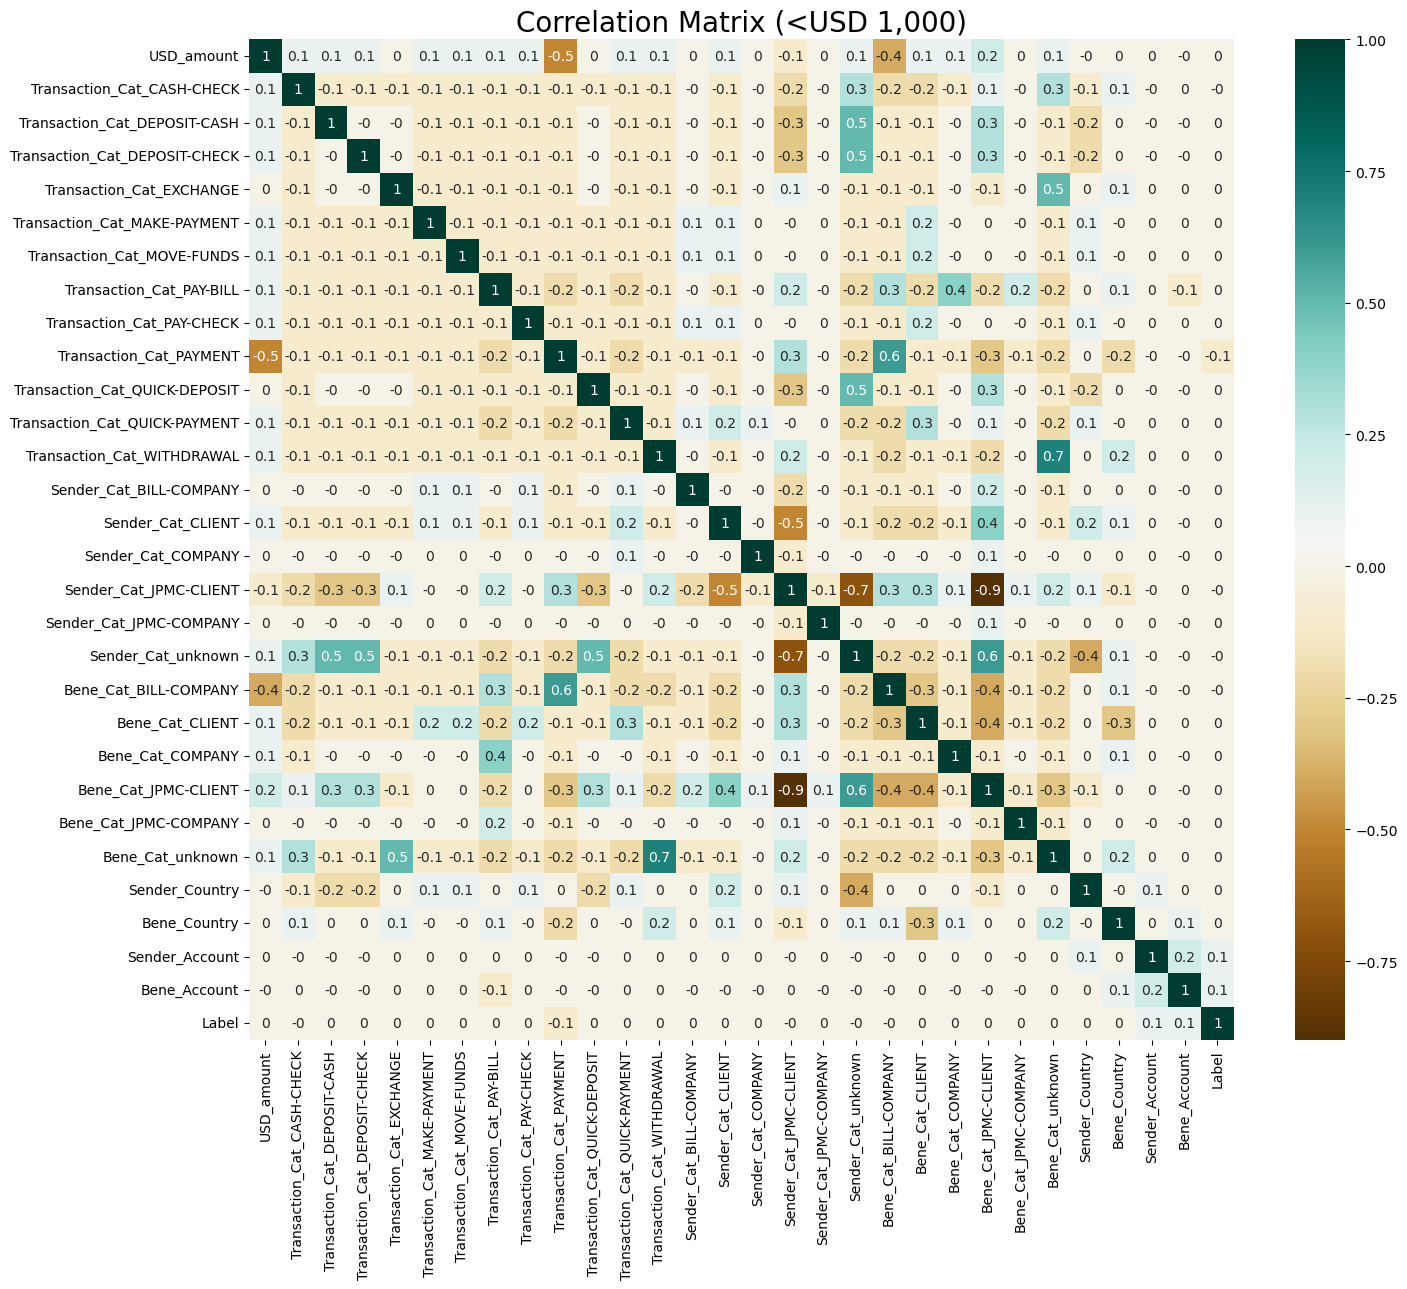

In [17]:
fig = plt.figure(figsize=(15, 13))
sns.heatmap(corr, annot =True, cmap='BrBG')
plt.title('Correlation Matrix (<USD 1,000)', fontsize='20')
fig.tight_layout()
plt.savefig('images/corr_matrix.png')
plt.show()

In [18]:
X_trans = df_trans.drop('Label', axis = 1)
y_trans = df_trans['Label']

### Dimension Reduction and Feature Selection
Exploring different methods of dimension reduction and feature selection

#### PCA for Data Visualization
**Observations: It requires many components to retain 95% of explained variance**

In [19]:
scaler = MinMaxScaler()
X_trans_scaled = scaler.fit_transform(X_trans)
pca = PCA(n_components =0.95)
X_pca = pca.fit_transform(X_trans_scaled)
print("Explained variance ratio: %s" % str(pca.explained_variance_ratio_))
print("Number of components: %s" % str(pca.n_components_))

Explained variance ratio: [0.26493658 0.14716843 0.11182823 0.07367696 0.06424504 0.05137419
 0.0348168  0.03471268 0.03270097 0.02944952 0.02662156 0.02205203
 0.0202728  0.01763434 0.01755101 0.01512956]
Number of components: 16


In [20]:
columns = ['component_%i' % i for i in range(pca.n_components_)]
X_pca  = pd.DataFrame(X_pca, columns = columns, index = df_trans.index)
X_pca['Label'] = y_trans
X_pca.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,Label
0,-0.291728,0.489425,0.874835,-0.173496,0.152993,0.011313,0.000158,-0.000277,0.054117,0.007496,0.096053,0.872464,-0.380890,-0.001061,0.002196,-0.047627,0.0
1,-0.301271,0.887484,-0.737674,0.029190,0.158065,-0.565723,0.002699,-0.001384,-0.021313,-0.078078,0.059996,-0.037325,-0.050318,0.000129,0.000498,-0.057158,0.0
2,1.372692,-0.279687,0.076516,-0.059091,-0.430564,-0.238193,0.000881,-0.001426,-0.288851,-0.199499,0.183162,0.070854,-0.068864,-0.620347,-0.529185,0.078028,0.0
3,0.431629,0.211500,-0.021529,0.188546,-0.004798,0.486972,-0.169398,0.796158,0.017946,-0.183565,0.512698,0.216664,0.622755,0.001410,0.000477,-0.128859,0.0
4,1.370924,-0.283858,0.074997,-0.063002,-0.428994,-0.238220,0.000818,-0.001335,-0.289970,-0.189745,0.168669,0.072803,-0.067847,0.769574,-0.268409,0.074923,0.0


In [21]:
#sns.scatterplot(data = X_pca, x = 'component_0', y = 'component_1', hue = 'Fraud', palette = 'Set2', alpha= 0.5)

In [22]:
#px.scatter_3d(X_pca, x='component_0', y='component_1', z='component_2', color='Fraud', title ='PCA Results')

**Handling multi-correllated features with hierachical feature clustering**

Use a threshold to select one feature in each cluster. 

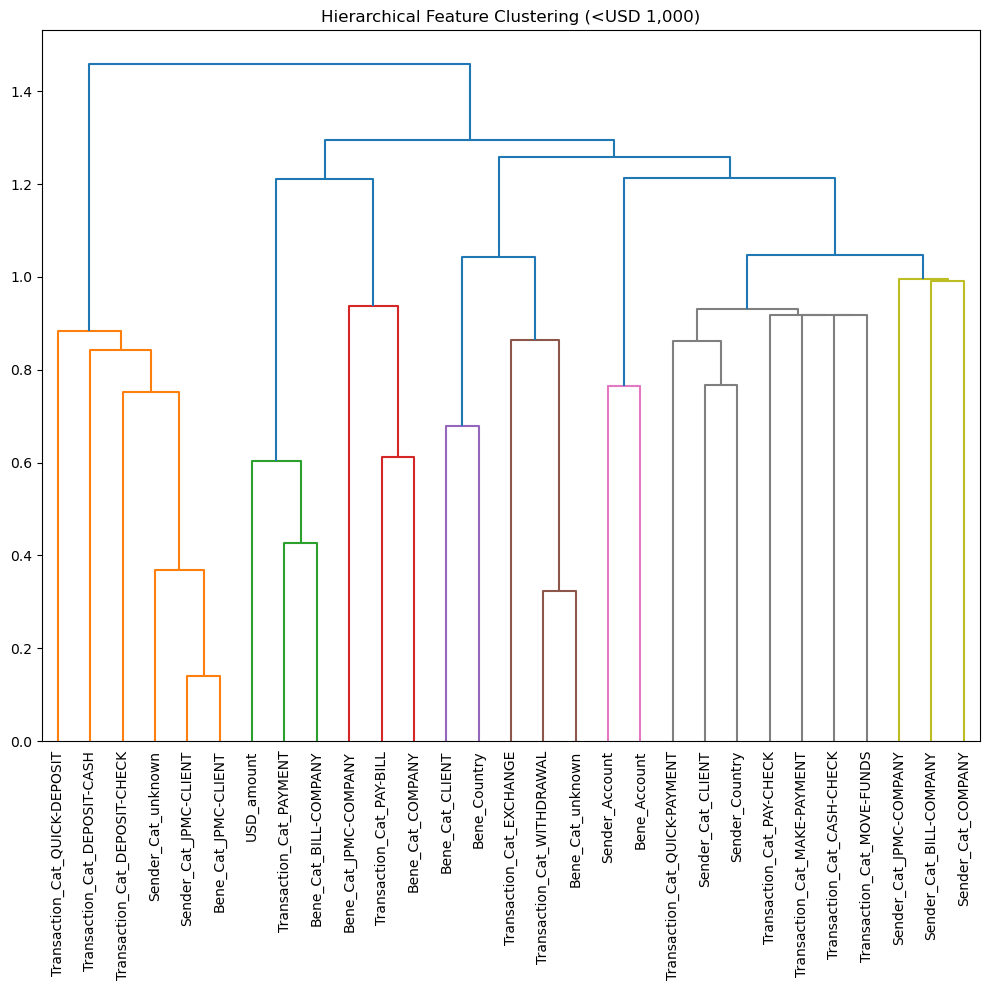

In [23]:
fig = plt.figure(figsize=(10, 10))
distance_matrix = 1 - np.abs(X_trans.corr())
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels = X_trans.columns, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.title('Hierarchical Feature Clustering (<USD 1,000)')
fig.tight_layout()
plt.savefig('images/feature_clustering.png')

In [24]:
threshold = 0.6 #set the threshold
cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_feature_names_cluster = X_trans.columns[selected_features]
selected_feature_names_cluster

Index(['USD_amount', 'Transaction_Cat_CASH-CHECK',
       'Transaction_Cat_DEPOSIT-CASH', 'Transaction_Cat_DEPOSIT-CHECK',
       'Transaction_Cat_EXCHANGE', 'Transaction_Cat_MAKE-PAYMENT',
       'Transaction_Cat_MOVE-FUNDS', 'Transaction_Cat_PAY-BILL',
       'Transaction_Cat_PAY-CHECK', 'Transaction_Cat_PAYMENT',
       'Transaction_Cat_QUICK-DEPOSIT', 'Transaction_Cat_QUICK-PAYMENT',
       'Transaction_Cat_WITHDRAWAL', 'Sender_Cat_BILL-COMPANY',
       'Sender_Cat_CLIENT', 'Sender_Cat_COMPANY', 'Sender_Cat_JPMC-CLIENT',
       'Sender_Cat_JPMC-COMPANY', 'Bene_Cat_CLIENT', 'Bene_Cat_COMPANY',
       'Bene_Cat_JPMC-COMPANY', 'Sender_Country', 'Bene_Country',
       'Sender_Account', 'Bene_Account'],
      dtype='object')

#### Selecting features according to the k highest scores

In [25]:
kbest = SelectKBest(k=10)
kbest.fit(X_trans[selected_feature_names_cluster], y_trans)
mask = kbest.get_support()
Xfeatures = selected_feature_names_cluster
kbest_selected_features = Xfeatures[mask] 
print("Selected features: ", kbest_selected_features.shape[0])
print(Xfeatures[mask]) 
selected_feature_names_kbest = Xfeatures[mask]

Selected features:  10
Index(['USD_amount', 'Transaction_Cat_CASH-CHECK', 'Transaction_Cat_PAYMENT',
       'Transaction_Cat_QUICK-PAYMENT', 'Sender_Cat_CLIENT', 'Bene_Cat_CLIENT',
       'Sender_Country', 'Bene_Country', 'Sender_Account', 'Bene_Account'],
      dtype='object')


**Use the features selected by the feature clustering method and KBest to both reduce dimension and handle multicollinear features**

In [26]:
selected_feature_names = selected_feature_names_kbest
selected_feature_names

Index(['USD_amount', 'Transaction_Cat_CASH-CHECK', 'Transaction_Cat_PAYMENT',
       'Transaction_Cat_QUICK-PAYMENT', 'Sender_Cat_CLIENT', 'Bene_Cat_CLIENT',
       'Sender_Country', 'Bene_Country', 'Sender_Account', 'Bene_Account'],
      dtype='object')

## 5. Declare X and y

In [27]:
X = X_trans[selected_feature_names]
y = y_trans

## 6. Train/Test Split

With the data prepared, split it into a train, calibration and test set.

In [28]:
#Use stratify=y to preserve the class proportion
random_state = 40
X_train_org, X_test_temp, y_train_org, y_test_temp = train_test_split(X, y, test_size = 0.4, stratify = y, random_state=random_state)
X_cal_org, X_test_org, y_cal_org, y_test_org = train_test_split(X_test_temp, y_test_temp, test_size = 0.5, stratify = y_test_temp, random_state=random_state)
print(X_train_org.shape, X_cal_org.shape, X_test_org.shape, y_train_org.shape, y_cal_org.shape, y_test_org.shape)
print(y.value_counts(normalize=True))

(854409, 10) (284803, 10) (284803, 10) (854409,) (284803,) (284803,)
Label
0.0    0.979056
1.0    0.020944
Name: proportion, dtype: float64


## 7. Dataset Balancing

#### Balancing the Train Set

In [29]:
# define oversampling strategy and fit, apply the transform
oversample = SMOTE(sampling_strategy = 0.3)
X_train, y_train = oversample.fit_resample(X_train_org, y_train_org)

In [30]:
# define undersampling strategy and fit, apply the transform
undersample = RandomUnderSampler(sampling_strategy = 1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

#### Balancing the Calibration Set and Test Set

In [31]:
# fit and apply the transform for oversampling
X_cal, y_cal = oversample.fit_resample(X_cal_org, y_cal_org)
X_test, y_test = oversample.fit_resample(X_test_org, y_test_org)

In [32]:
# fit and apply the transform for undersampling
X_cal, y_cal = undersample.fit_resample(X_cal, y_cal)
X_test, y_test = undersample.fit_resample(X_test, y_test)

#### View balancing results

In [33]:
#Count the number of legit and fraud samples and place the values into a dataframe
data = [['Before Balancing - Train', y_train_org.value_counts()[0], y_train_org.value_counts()[1], len(y_train_org)],
        ['After Balancing - Train', y_train.value_counts()[0], y_train.value_counts()[1], len(y_train)],
        ['Before Balancing - Calibration', y_cal_org.value_counts()[0], y_cal_org.value_counts()[1], len(y_cal_org)],
        ['After Balancing - Calibration', y_cal.value_counts()[0], y_cal.value_counts()[1], len(y_cal)],
        ['Before Balancing - Test',y_test_org.value_counts()[0], y_test_org.value_counts()[1], len(y_test_org)],
        ['After Balancing - Test',y_test.value_counts()[0], y_test.value_counts()[1], len(y_test)]
       ]
df_dataset = pd.DataFrame(data = data, columns=['Low Amount Dataset', '#Legit','#Fraud','Total'])
df_dataset

,Low Amount Dataset,#Legit,#Fraud,Total
0,Before Balancing - Train,836514,17895,854409
1,After Balancing - Train,250954,250954,501908
2,Before Balancing - Calibration,278838,5965,284803
3,After Balancing - Calibration,83651,83651,167302
4,Before Balancing - Test,278838,5965,284803
5,After Balancing - Test,83651,83651,167302


In [76]:
#dfi.export(df_dataset,'images/data_balancing.png', table_conversion="matplotlib")

# 8. Build A Baseline Model

Before we build our first model, we want to establish a baseline.

**Aim to have Accuracy > 50% and F1 > 0.13**

In [35]:
f_score = make_scorer(fbeta_score, beta=1)
scoring = {"accuracy": "accuracy", "fbeta": f_score}
df_scores = pd.DataFrame(columns=['Model Name','Train Time',
                                  'ACC - Train','ACC - Val', 'ACC - Test',
                                  'F1 - Train','F1 - Val', 'F1 - Test',
                                  ])
best_pipes = []

In [36]:
def get_score(model_name, scores, elapsed_time):
    #train_time = scores['fit_time'].sum() + scores['score_time'].sum()
    best_pipes.append(scores['estimator'][pd.Series(scores['test_accuracy']).idxmax()])
    train_time = "%.2f" % (elapsed_time)
    accuracy_train = "%.2f (+/- %.2f)" % (round(scores['train_accuracy'].mean(),2), scores['train_accuracy'].std())
    accuracy_val = "%.2f (+/- %.2f)" % (round(scores['test_accuracy'].mean(),2), scores['test_accuracy'].std())
    fbeta_train = "%.2f (+/- %.2f)" % (round(scores['train_fbeta'].mean(),2), scores['train_fbeta'].std())
    fbeta_val = "%.2f (+/- %.2f)" % (round(scores['test_fbeta'].mean(),2), scores['test_fbeta'].std())
    new_score = {'Model Name': model_name, 'Train Time': train_time,
                 'ACC - Train': accuracy_train, 'ACC - Val': accuracy_val,'ACC - Test': '',
                 'F1 - Train': fbeta_train, 'F1 - Val': fbeta_val, 'F1 - Test': '',                 
                }
    return new_score

In [37]:
dummy_pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', DummyClassifier(strategy="most_frequent"))])
start_time = time.time()
dummy_pipe.fit(X_train, y_train)
scores = cross_validate(dummy_pipe, X_train, y_train, scoring = scoring, cv=5, return_train_score=True, return_estimator=True)
elapsed_time = time.time() - start_time
new_score = get_score('Baseline', scores, elapsed_time)
df_scores.loc[len(df_scores)] = new_score
df_scores

,Model Name,Train Time,ACC - Train,ACC - Val,ACC - Test,F1 - Train,F1 - Val,F1 - Test
0,Baseline,3.84,0.50 (+/- 0.00),0.50 (+/- 0.00),,0.13 (+/- 0.27),0.13 (+/- 0.27),


## 9. Default Model Comparisons

**Observations:**

**The most computative expensive model is the AB model. AB also provides the lowest score. DT has a very decent score but it is slower than XGB and HGBT because it built a very deep tree.**

In [38]:
model_pipes = {
    'DT': DecisionTreeClassifier(random_state=random_state),
    'XGB': XGBClassifier(random_state=random_state),  
    'HGBT': HistGradientBoostingClassifier(random_state=random_state),
    'AB': AdaBoostClassifier(random_state=random_state)
    #'LR': Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression(random_state=random_state))]),
}


In [39]:
for pipe_name, pipe in model_pipes.items():
    start_time = time.time()
    scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True, return_estimator=True)
    elapsed_time = time.time() - start_time
    display_name = f"{pipe_name} - Default"
    new_score = get_score(display_name, scores, elapsed_time)
    df_scores.loc[len(df_scores)] = new_score
df_scores

,Model Name,Train Time,ACC - Train,ACC - Val,ACC - Test,F1 - Train,F1 - Val,F1 - Test
0,Baseline,3.84,0.50 (+/- 0.00),0.50 (+/- 0.00),,0.13 (+/- 0.27),0.13 (+/- 0.27),
1,DT - Default,77.74,1.00 (+/- 0.00),0.92 (+/- 0.04),,1.00 (+/- 0.00),0.92 (+/- 0.06),
2,XGB - Default,13.22,0.94 (+/- 0.01),0.93 (+/- 0.06),,0.94 (+/- 0.01),0.92 (+/- 0.07),
3,HGBT - Default,46.88,0.93 (+/- 0.01),0.93 (+/- 0.06),,0.93 (+/- 0.02),0.92 (+/- 0.07),
4,AB - Default,431.96,0.87 (+/- 0.01),0.87 (+/- 0.03),,0.87 (+/- 0.01),0.87 (+/- 0.03),


In [75]:
#dfi.export(df_scores,'images/scores_default.png', table_conversion="matplotlib")

In [41]:
#Get the tree depth of the Decision Trees model
best_pipes[1].get_depth()

52

## 10. Improved Model Comparision

### Functions to train models and retrieve train and validation scores

In [42]:
def get_grid_score(model_name, grid, elapsed_time):
    results = grid.cv_results_
    index = grid.best_index_
    #train_time = "%.2f" % (results['mean_fit_time'].sum() + results['mean_score_time'].sum())
    train_time = "%.2f" % (elapsed_time)
    accuracy_train = "%.2f (+/- %.2f)" % (round(results['mean_train_accuracy'][index],2), results['std_train_accuracy'][index])
    accuracy_val = "%.2f (+/- %.2f)" % (round(results['mean_test_accuracy'][index],2), results['std_test_accuracy'][index])
    fbeta_train = "%.2f (+/- %.2f)" % (round(results['mean_train_fbeta'][index],2), results['std_train_fbeta'][index])
    fbeta_val = "%.2f (+/- %.2f)" % (round(results['mean_test_fbeta'][index],2), results['std_test_fbeta'][index])
    new_score = {'Model Name': model_name, 'Train Time': train_time,
                 'F1 - Train': fbeta_train, 'F1 - Val': fbeta_val,'F1 - Test': '',
                 'ACC - Train': accuracy_train, 'ACC - Val': accuracy_val,'ACC - Test': ''
                }
    print('Best params:', grid.best_params_)
    print('Best model score:', round(grid.best_score_,2))
    return new_score

In [43]:
n_iter_search = 10
def train_model(model_name, model_pipes, X_train, y_train, suffix):
    grid_search = RandomizedSearchCV(model_pipes[model_name], params[model_name], cv = 10, scoring = scoring, n_jobs = 4,
                                     refit="accuracy", return_train_score=True, error_score = "raise", n_iter=n_iter_search, random_state = random_state)
    start_time = time.time()
    grid_fit = grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to train: {elapsed_time:.3f} seconds")
    display_name = f"{model_name} - {suffix}"
    new_score = get_grid_score(display_name, grid_fit, elapsed_time)
    df_scores.loc[len(df_scores)] = new_score
    return grid_fit

### Model pipelines and parameters

In [44]:
params = {'DT': {'criterion':['gini','entropy'],
                 'max_depth': np.arange(5, 20, dtype=int),
                 #'min_samples_split': loguniform(0.0001, 1),
                 #'min_samples_leaf':np.arange(1, 100, dtype=int),
                 'min_impurity_decrease': loguniform(0.00001, 1),
                 #'min_weight_fraction_leaf': loguniform(0.001, 0.5)
                },
          'XGB': {'num_round': [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)],
                  'eta': loguniform(0.01, 10),
                  #'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 150, num = 10)],
                  'max_depth': np.arange(2, 7, dtype=int),
                  #'min_child_weight': loguniform(0.0001, 1),
                  #'gamma': loguniform(0.0001, 1),
                  #'subsample': loguniform(0.0001, 1), 
                 },
          'HGBT': {'max_iter' : [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)],
                   'learning_rate' : loguniform(0.01, 10),                   
                   'max_depth': np.arange(2, 7, dtype=int)
                  }
}


### Hyper-parameter tuning on the Train dataset

**Observations:**

**DT is the fastest but it has a lowest score (as the complexity of the tree was reduced). XGB and HGBT have similar scores but XGB is faster**

In [45]:
grid_list = {}

In [46]:
grid_list['DT'] = train_model('DT', model_pipes, X_train, y_train, 'Improved')

Elapsed time to train: 152.197 seconds
Best params: {'criterion': 'gini', 'max_depth': 16, 'min_impurity_decrease': 1.8916038991795527e-05}
Best model score: 0.91


In [47]:
grid_list['XGB'] = train_model('XGB', model_pipes, X_train, y_train, 'Improved')

Elapsed time to train: 186.298 seconds
Best params: {'eta': 1.0981254422871438, 'max_depth': 4, 'num_round': 133}
Best model score: 0.93


In [48]:
grid_list['HGBT'] = train_model('HGBT', model_pipes, X_train, y_train, 'Improved')

Elapsed time to train: 369.227 seconds
Best params: {'learning_rate': 0.3163755793049395, 'max_depth': 3, 'max_iter': 188}
Best model score: 0.93


In [49]:
pd.set_option('display.max_colwidth', None)
df_scores

,Model Name,Train Time,ACC - Train,ACC - Val,ACC - Test,F1 - Train,F1 - Val,F1 - Test
0,Baseline,3.84,0.50 (+/- 0.00),0.50 (+/- 0.00),,0.13 (+/- 0.27),0.13 (+/- 0.27),
1,DT - Default,77.74,1.00 (+/- 0.00),0.92 (+/- 0.04),,1.00 (+/- 0.00),0.92 (+/- 0.06),
2,XGB - Default,13.22,0.94 (+/- 0.01),0.93 (+/- 0.06),,0.94 (+/- 0.01),0.92 (+/- 0.07),
3,HGBT - Default,46.88,0.93 (+/- 0.01),0.93 (+/- 0.06),,0.93 (+/- 0.02),0.92 (+/- 0.07),
4,AB - Default,431.96,0.87 (+/- 0.01),0.87 (+/- 0.03),,0.87 (+/- 0.01),0.87 (+/- 0.03),
5,DT - Improved,152.20,0.91 (+/- 0.01),0.91 (+/- 0.07),,0.91 (+/- 0.01),0.90 (+/- 0.09),
6,XGB - Improved,186.30,0.94 (+/- 0.01),0.93 (+/- 0.09),,0.94 (+/- 0.01),0.92 (+/- 0.13),
7,HGBT - Improved,369.23,0.93 (+/- 0.01),0.93 (+/- 0.09),,0.93 (+/- 0.01),0.91 (+/- 0.13),


In [74]:
#dfi.export(df_scores.iloc[np.r_[0:1, -3:0]],'images/scores_improved.png', table_conversion="matplotlib")

### Fit time and score curves on the Train dataset

**Observations:**

**The trend lines below suggest that XGB was the best in terms of scalability. The fit time of DT was the worst, increasing exponentially when the number of samples was over 100,000.**

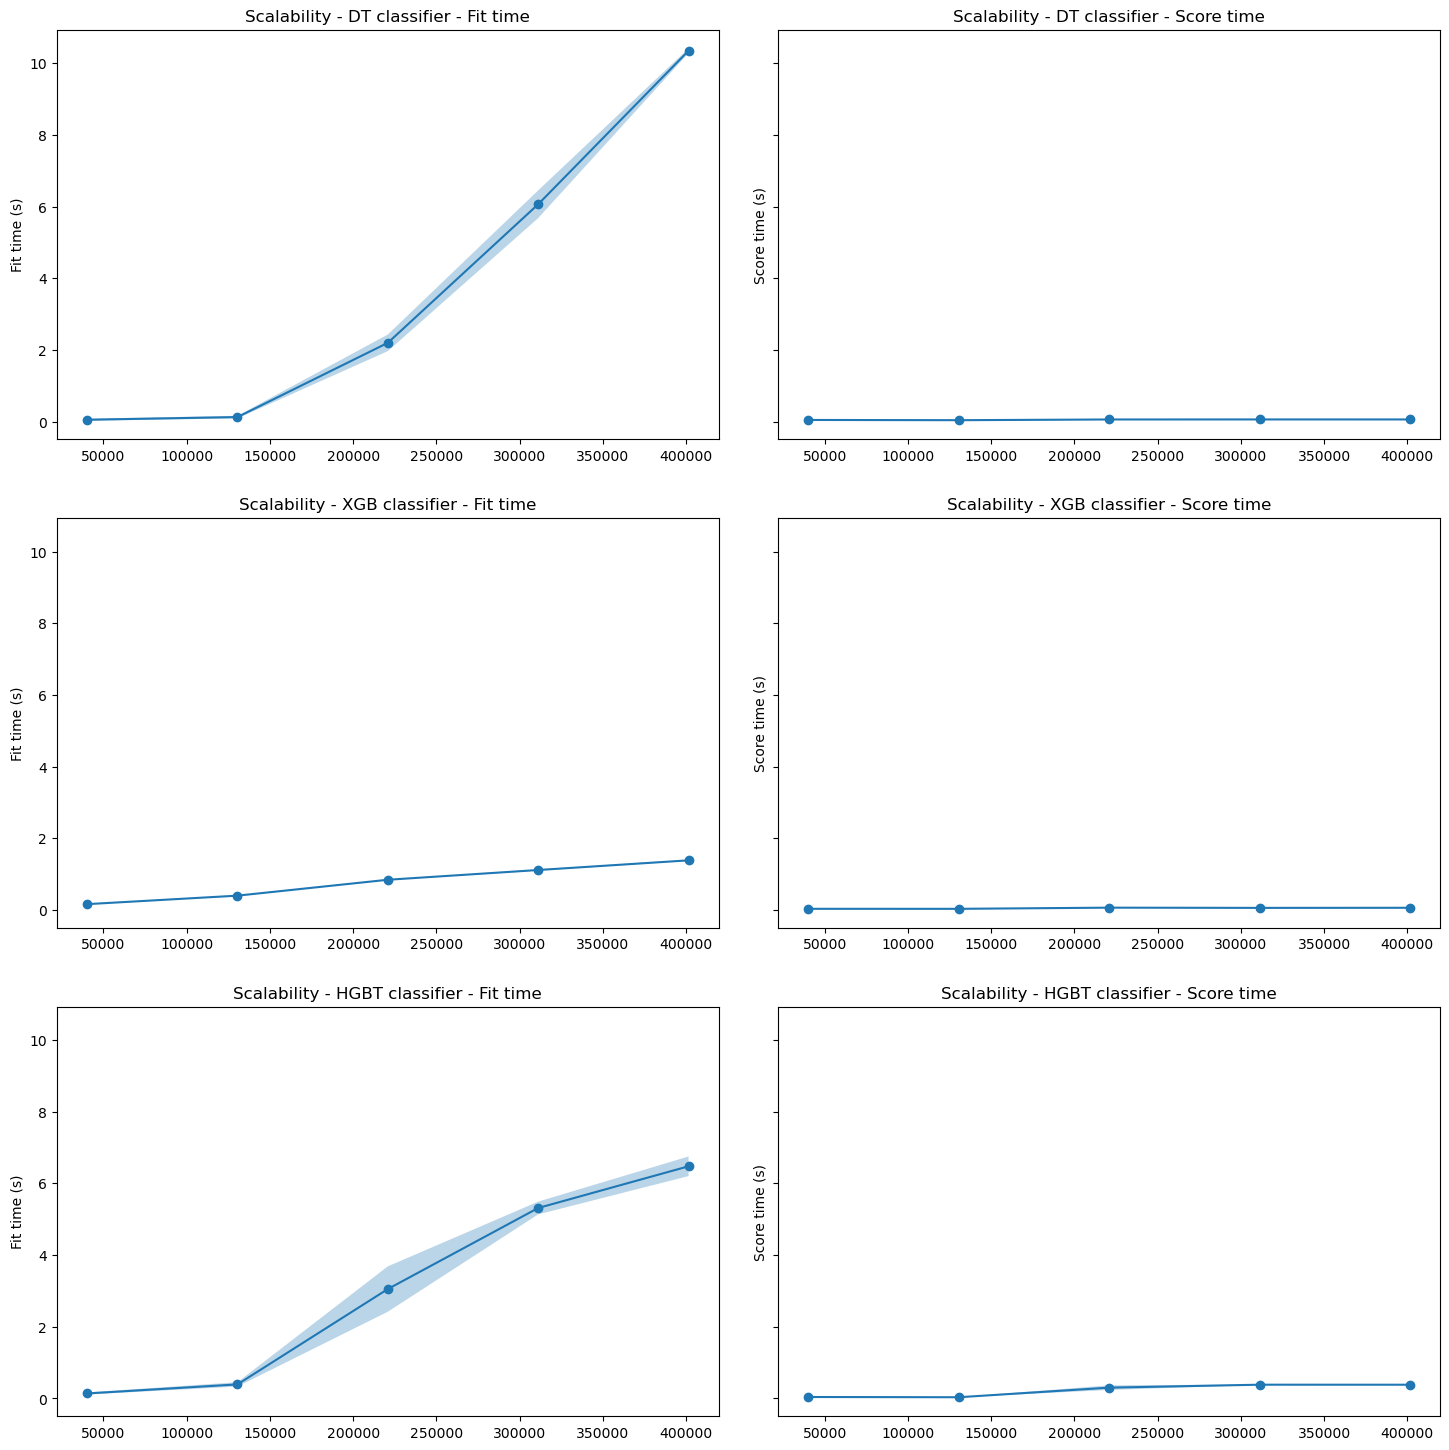

In [51]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "scoring": "accuracy",
    "return_times": True
}

i = 0
grid_positions = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
for name, grid in grid_list.items():
    ax_idx = grid_positions[i]
    estimator = grid.best_estimator_
    train_sizes, _, test_scores, fit_times, score_times = learning_curve(estimator, **common_params)
    ax[ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("Fit time (s)")
    ax[ax_idx].set_title(
        f"Scalability - {name} classifier - Fit time"
    )
    
    ax_idx = grid_positions[i+1]
    ax[ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("Score time (s)")
    ax[ax_idx].set_title(
        f"Scalability - {name} classifier - Score time"
    )
    i = i + 2
fig.tight_layout(pad = 2.5)
plt.savefig('images/scalability.png')

### Model learning curves on the Train dataset

**Observations:**

For all three models, the training scores started high and decreased when the number of samples increased and converged to the validation scores. Therefore, all three models might not benefit much from adding more samples because the train and validation scores converged and relatively flatted out.

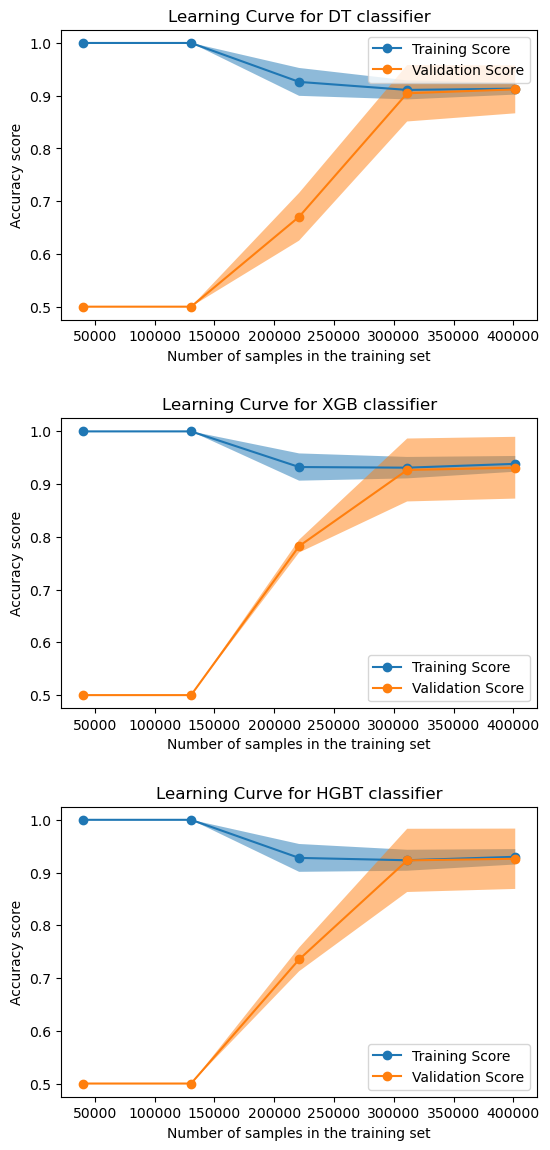

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "accuracy",
    "score_name": "Accuracy score",
}
ax_idx = 0
grid_positions = [0, 1, 2]
for name, grid in grid_list.items():
    estimator = grid.best_estimator_
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[grid_positions[ax_idx]])
    handles, label = ax[grid_positions[ax_idx]].get_legend_handles_labels()
    ax[grid_positions[ax_idx]].legend(handles[:2], ["Training Score", "Validation Score"])
    ax[grid_positions[ax_idx]].set_title(f"Learning Curve for {name} classifier")
    ax_idx = ax_idx + 1
fig.tight_layout(pad = 2.5)
plt.savefig('images/learning_curves.png')

### Calibrate models on the Calibration dataset and plot probability calibration curves on the Test set

**Observations:**

**Calibrate the classifiers so that estimates of the class probabilities (e.g. the output of the predict_proba method) can be interpreted as a confidence level of the prediction. After calibrating, predicted probabilities could be used for decision making. Three different fraudulent management procedures could be developed for the High, Medium, and Low probability groups. In addition, the probabilities could be used for long-term model monitoring and improvement after deployment.**

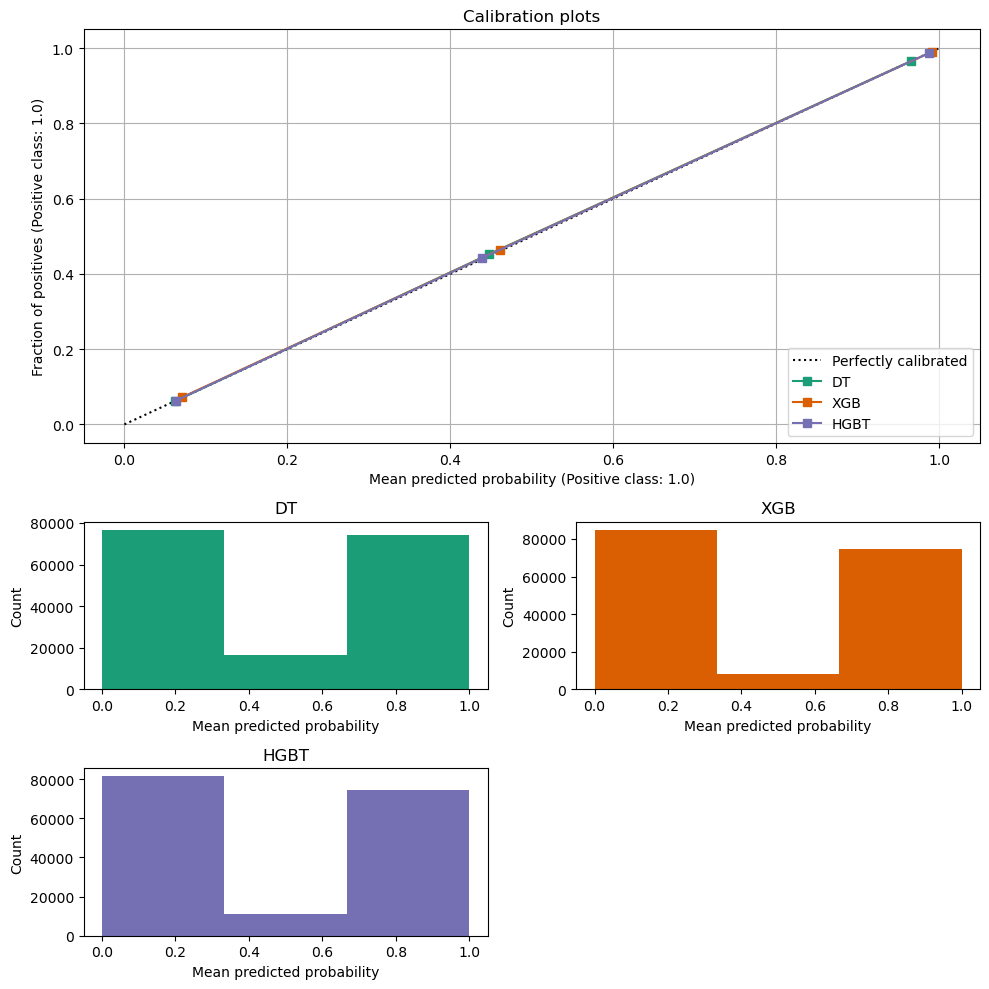

In [53]:
clf_list = {}
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
i = 0
for name, grid in grid_list.items():
    calibrated_clf = CalibratedClassifierCV(grid.best_estimator_, cv="prefit", method="isotonic").fit(X_cal, y_cal)
    clf_list[name] = calibrated_clf
    print(calibrated_clf.calibrated_classifiers_)
    display = CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_test,
        y_test,
        n_bins=3,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    i = i + 1
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
i = 0
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for name, clf in clf_list.items():
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=3,
        label=name,
        color=colors(i),
    )
    i = i + 1
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.savefig('images/calibration_low_amount.png')
plt.show()

### Functions to retrieve scores and compare models

In [54]:
def get_test_score(model_name, y_pred, y_test, suffix):
    accuracy_test = f"{accuracy_score(y_test, y_pred):.2f}"
    fbeta_test = f"{fbeta_score(y_test, y_pred, beta = 1):.2f}"
    if suffix == '':
        display_name = model_name
    else:
        display_name = f"{model_name} - {suffix}"
    row_idx = df_scores.index.get_loc(df_scores[df_scores['Model Name'] == display_name].index[0])
    df_scores.iloc[row_idx, df_scores.columns.tolist().index('ACC - Test')] = accuracy_test
    df_scores.iloc[row_idx, df_scores.columns.tolist().index('F1 - Test')] = fbeta_test

In [55]:
def compare_model(model_name, clf, cm_ax, pr_ax, roc_ax, chance_level, X_test, y_test, suffix):
    y_pred = clf.predict(X_test)
    get_test_score(model_name, y_pred, y_test, suffix)
    display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels = ['Legit', 'Fraud'], ax=cm_ax)
    _ = display.ax_.set_title(model_name, size=title_size)
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=model_name, plot_chance_level=chance_level, ax=pr_ax)
    RocCurveDisplay.from_estimator(clf, X_test, y_test, name=model_name, plot_chance_level=chance_level, ax=roc_ax)


### Compare models on the Test set

**Observations:**

**All three models yielded very decent predictions on the Low Amount test set. XGB and HGBT take the lead in terms of performance, followed by DT.** 

**XGB has the best F1 score. The Precision-Recall curves and ROC-AUC curves show that DT is lightly trailing behind. XGB and HGBT are very similar although the XGB has the highest AP score.**

In [56]:
get_test_score("Baseline", best_pipes[0].predict(X_test), y_test, '')
get_test_score("DT", best_pipes[1].predict(X_test), y_test, 'Default')
get_test_score("XGB", best_pipes[2].predict(X_test), y_test, 'Default')
get_test_score("HGBT", best_pipes[3].predict(X_test), y_test, 'Default')
df_scores

,Model Name,Train Time,ACC - Train,ACC - Val,ACC - Test,F1 - Train,F1 - Val,F1 - Test
0,Baseline,3.84,0.50 (+/- 0.00),0.50 (+/- 0.00),0.50,0.13 (+/- 0.27),0.13 (+/- 0.27),0.00
1,DT - Default,77.74,1.00 (+/- 0.00),0.92 (+/- 0.04),0.90,1.00 (+/- 0.00),0.92 (+/- 0.06),0.90
2,XGB - Default,13.22,0.94 (+/- 0.01),0.93 (+/- 0.06),0.94,0.94 (+/- 0.01),0.92 (+/- 0.07),0.94
3,HGBT - Default,46.88,0.93 (+/- 0.01),0.93 (+/- 0.06),0.93,0.93 (+/- 0.02),0.92 (+/- 0.07),0.93
4,AB - Default,431.96,0.87 (+/- 0.01),0.87 (+/- 0.03),,0.87 (+/- 0.01),0.87 (+/- 0.03),
5,DT - Improved,152.20,0.91 (+/- 0.01),0.91 (+/- 0.07),,0.91 (+/- 0.01),0.90 (+/- 0.09),
6,XGB - Improved,186.30,0.94 (+/- 0.01),0.93 (+/- 0.09),,0.94 (+/- 0.01),0.92 (+/- 0.13),
7,HGBT - Improved,369.23,0.93 (+/- 0.01),0.93 (+/- 0.09),,0.93 (+/- 0.01),0.91 (+/- 0.13),


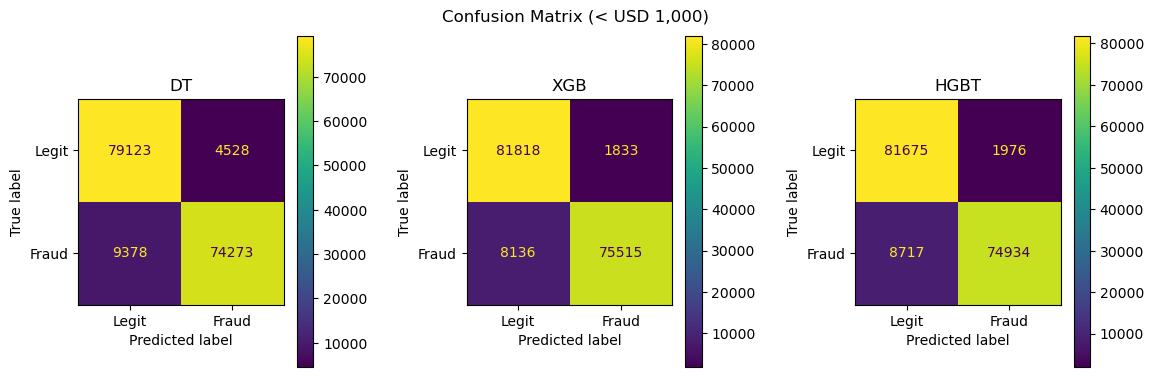

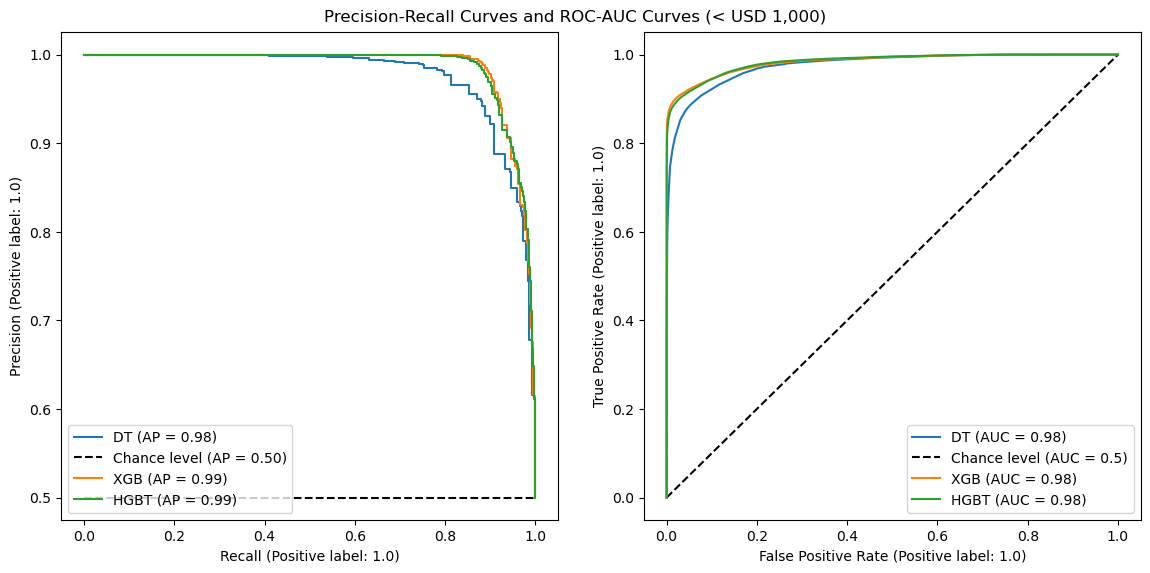

In [57]:
title_size = 12
plt.rcParams.update({'font.size':10})
display_labels = ["No", "Yes"]  
colorbar = False
values_format = ".2f"  

fig_cm, axes_cm = plt.subplots(1, 3, figsize=(12, 4))
fig_pr_roc, axes_pr_roc = plt.subplots(1, 2, figsize=(12, 6))

i = 0
chance_level = True
for name, clf in clf_list.items():
    cm_ax = axes_cm[i]
    pr_ax = axes_pr_roc[0]
    roc_ax = axes_pr_roc[1]
    compare_model(name, clf, cm_ax, pr_ax, roc_ax, chance_level, X_test, y_test, 'Improved')
    i = i+1
    chance_level = False

fig_cm.tight_layout(pad = 2.5)
fig_cm.suptitle('Confusion Matrix (< USD 1,000)')
fig_cm.savefig('images/confusionmatrix25.png')
fig_pr_roc.tight_layout(pad = 2.5)
fig_pr_roc.suptitle('Precision-Recall Curves and ROC-AUC Curves (< USD 1,000)')
fig_pr_roc.savefig('images/compare25.png')

In [58]:
df_scores

,Model Name,Train Time,ACC - Train,ACC - Val,ACC - Test,F1 - Train,F1 - Val,F1 - Test
0,Baseline,3.84,0.50 (+/- 0.00),0.50 (+/- 0.00),0.50,0.13 (+/- 0.27),0.13 (+/- 0.27),0.00
1,DT - Default,77.74,1.00 (+/- 0.00),0.92 (+/- 0.04),0.90,1.00 (+/- 0.00),0.92 (+/- 0.06),0.90
2,XGB - Default,13.22,0.94 (+/- 0.01),0.93 (+/- 0.06),0.94,0.94 (+/- 0.01),0.92 (+/- 0.07),0.94
3,HGBT - Default,46.88,0.93 (+/- 0.01),0.93 (+/- 0.06),0.93,0.93 (+/- 0.02),0.92 (+/- 0.07),0.93
4,AB - Default,431.96,0.87 (+/- 0.01),0.87 (+/- 0.03),,0.87 (+/- 0.01),0.87 (+/- 0.03),
5,DT - Improved,152.20,0.91 (+/- 0.01),0.91 (+/- 0.07),0.92,0.91 (+/- 0.01),0.90 (+/- 0.09),0.91
6,XGB - Improved,186.30,0.94 (+/- 0.01),0.93 (+/- 0.09),0.94,0.94 (+/- 0.01),0.92 (+/- 0.13),0.94
7,HGBT - Improved,369.23,0.93 (+/- 0.01),0.93 (+/- 0.09),0.94,0.93 (+/- 0.01),0.91 (+/- 0.13),0.93


In [73]:
#dfi.export(df_scores.iloc[np.r_[0:1, -3:0]],'images/scores_full_test.png', table_conversion="matplotlib")

## 11. Model Interpretation
**XGB was selected for its performance, speed and ease of interpretation** 

In [60]:
selected_model_name = 'XGB'
selected_display_name = f"{selected_model_name} - Improved"
selected_clf = clf_list[selected_model_name]
model = selected_clf.calibrated_classifiers_[0].estimator

### Classification Report and Confusion Matrix

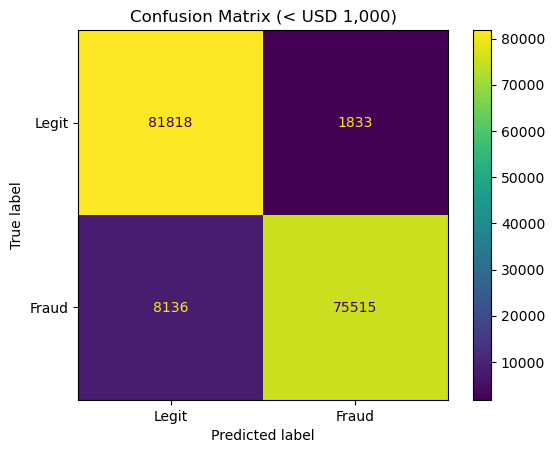

In [61]:
display = ConfusionMatrixDisplay.from_estimator(selected_clf, X_test, y_test, display_labels = ['Legit', 'Fraud'])
_ = display.ax_.set_title('Confusion Matrix (< USD 1,000)')
plt.savefig('images/confusionmatrix_dt.png')

In [62]:
target_labels = {
    0: 'Legit',
    1: 'Fraud'
}
y_pred = selected_clf.predict(X_test)
y_test_named = [target_labels[i] for i in y_test.values]
y_pred_named = [target_labels[i] for i in y_pred]
report = classification_report(y_test_named, y_pred_named, digits = 2, output_dict=True)

df_classification_report = pd.DataFrame(report).transpose().round(2)
df_classification_report

#classification_report(y_test_named, y_pred_named)

,precision,recall,f1-score,support
Fraud,0.98,0.90,0.94,83651.00
Legit,0.91,0.98,0.94,83651.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,167302.00
weighted avg,0.94,0.94,0.94,167302.00


In [72]:
#dfi.export(df_classification_report,'images/classification_report.png', table_conversion="matplotlib")

### Visualize the Decision Tree

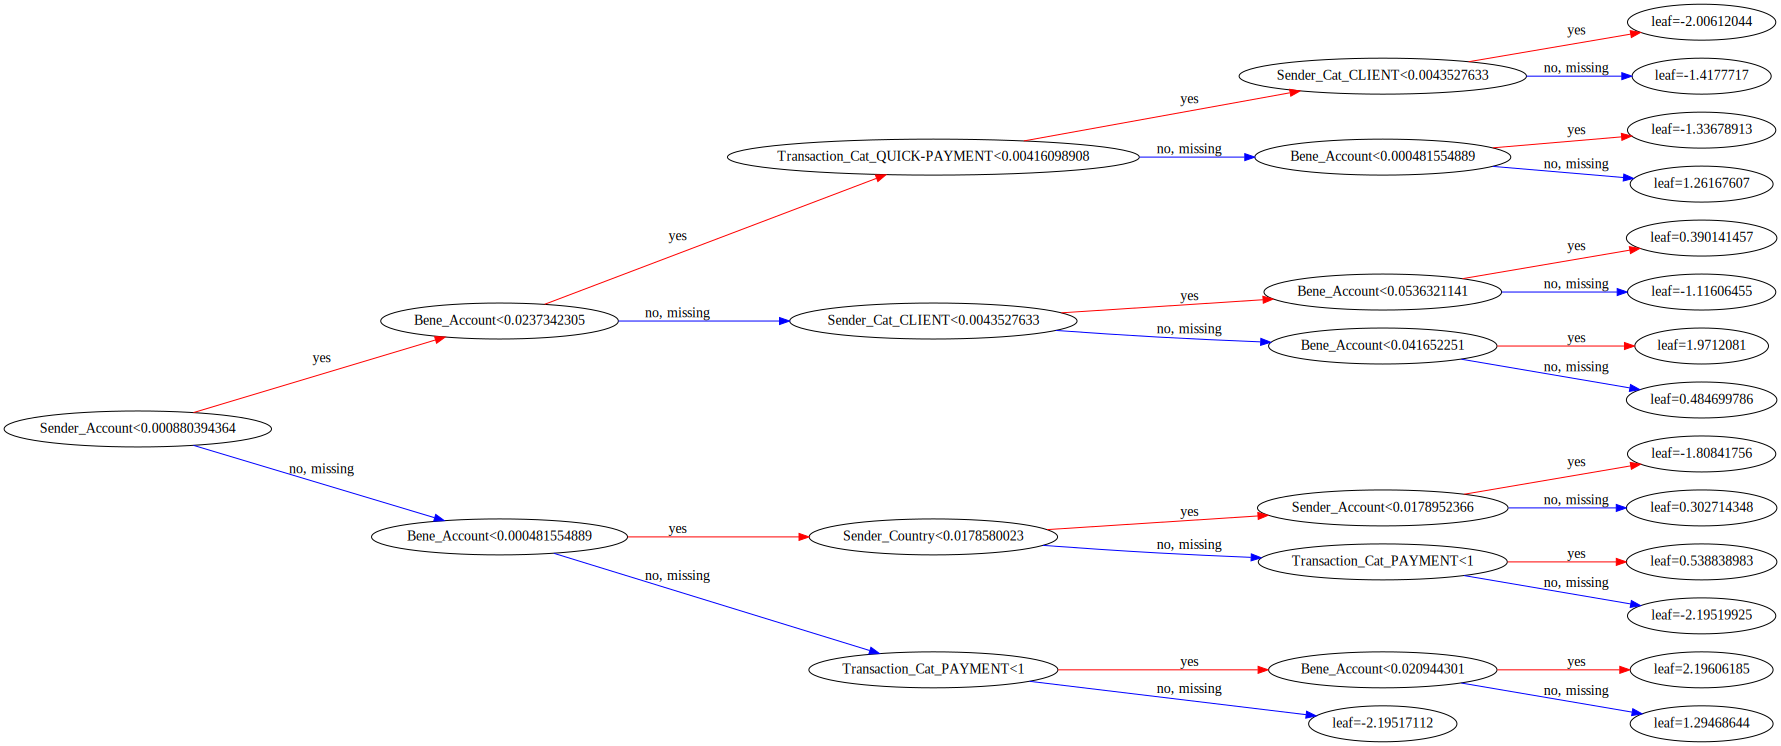

In [64]:
graph = xgb.to_graphviz(model, num_trees=0, rankdir='LR')
graph.render(format="png", filename="images/tree0")
graph

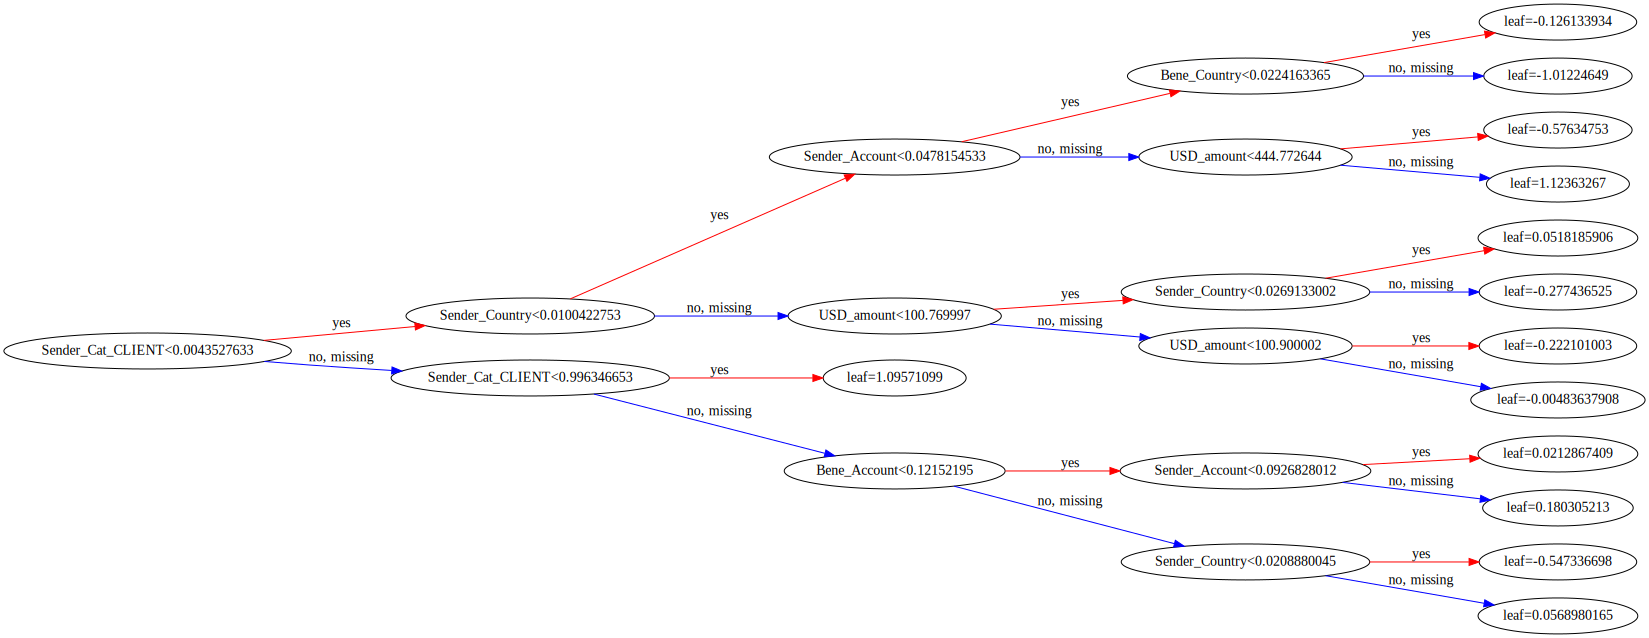

In [65]:
graph = xgb.to_graphviz(model, num_trees=99, rankdir='LR')
graph.render(format="png", filename="images/tree99")
graph

### Model Feature Importance

**Observations:**
For the total gain importance type, top features are "Sender_Account", "Sender_Country", and "Bene_Account"

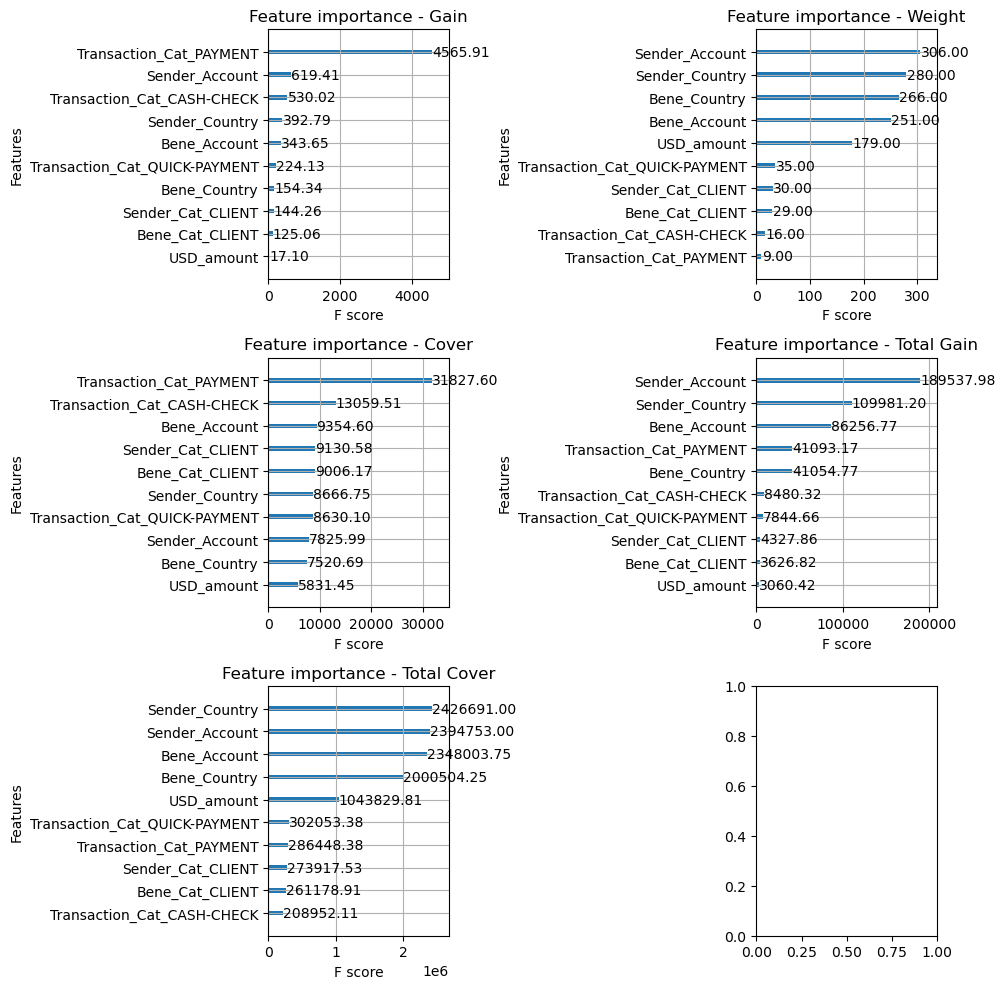

In [66]:
#Plot feature importance
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
xgb.plot_importance(model, importance_type='gain', values_format = '{v:.2f}', title='Feature importance - Gain', ax = axes[0,0])
xgb.plot_importance(model, importance_type='weight', values_format = '{v:.2f}', title='Feature importance - Weight', ax = axes[0,1])
xgb.plot_importance(model, importance_type='cover', values_format = '{v:.2f}', title='Feature importance - Cover', ax = axes[1,0])
xgb.plot_importance(model, importance_type='total_gain', values_format = '{v:.2f}', title='Feature importance - Total Gain', ax = axes[1,1])
xgb.plot_importance(model, importance_type='total_cover', values_format = '{v:.2f}', title='Feature importance - Total Cover', ax = axes[2,0])
plt.tight_layout()


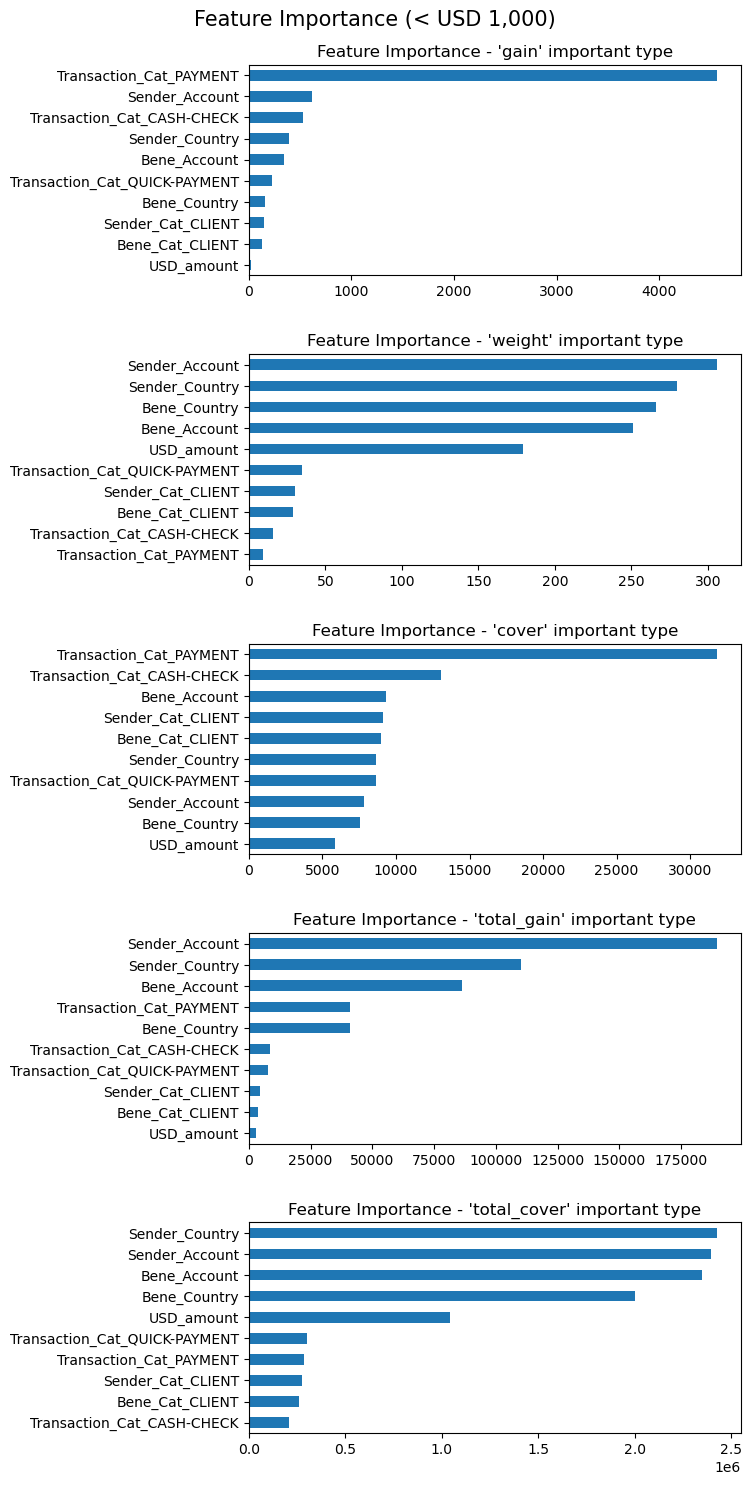

In [67]:
#Another view of feature importance
importance_types = ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
fig = plt.figure(figsize=(8,15))
k=0
num = 1
for importance_type in importance_types:
    feature_importances = list(model.get_booster().get_score(importance_type=importance_type).values())
    importances = pd.Series(feature_importances, index = selected_feature_names).sort_values(ascending=True)
    title = f"Feature Importance - '{importance_type}' important type"
    plt.subplot(5, 1, num) 
    ax = importances.plot.barh()
    ax.set_title(title)
    num = num +1

fig.tight_layout(pad = 2.5)
plt.suptitle("Feature Importance (< USD 1,000)", y = 1, fontsize = 15)
plt.savefig('images/feature_importance_mdi.png')

### Permutation Importance

**Observations:** Top features are "Sender_Account", "Sender_Country", and "Bene_Account"

In [68]:
def plot_permutation_importance(model, X, y, ax):
    result = permutation_importance(model, X, y, n_repeats=5, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()
    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels = X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


In [69]:
def model_permutation_importance(model, X_train, y_train, X_test, y_test):

    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))

    plot_permutation_importance(model, X_train, y_train, ax0)
    ax0.set_xlabel("Decrease in accuracy score")
    ax0.set_title("Permutation Importance - Train set")

    plot_permutation_importance(model, X_test, y_test, ax1)
    ax1.set_xlabel("Decrease in accuracy score")
    ax1.set_title("Permutation Importance - Test set")

    f.suptitle("Permutation Importance of the selected model (< USD 1,000)", y = 1)
    plt.tight_layout()
    plt.savefig('images/permutation.png')

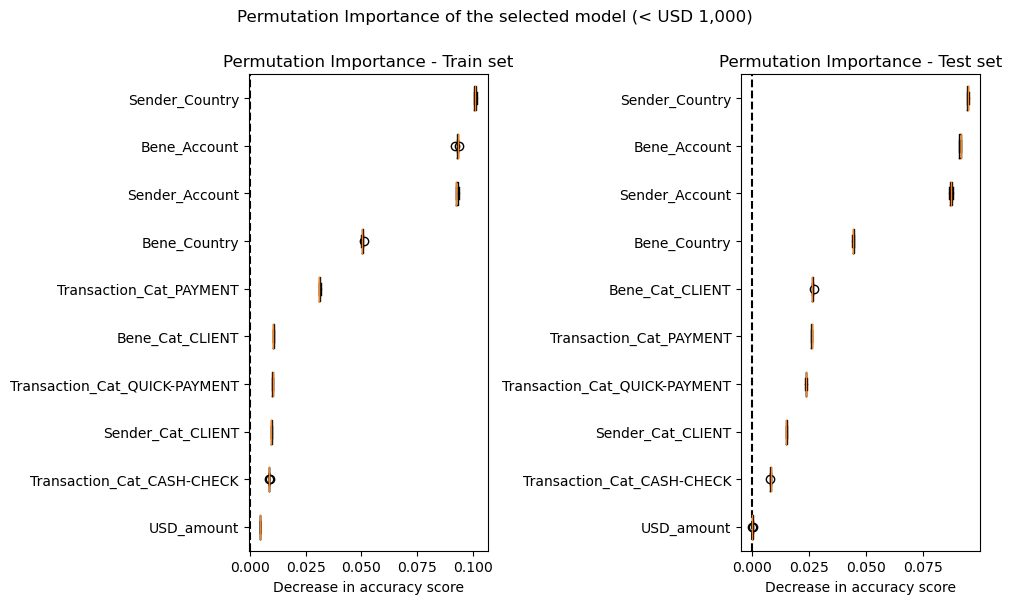

In [70]:
model_permutation_importance(model, X_train, y_train, X_test, y_test)

### Visualize Decision Boundary

**Observation:** Plot the decision boundary for the two most important features. The decision boundary is not complicated

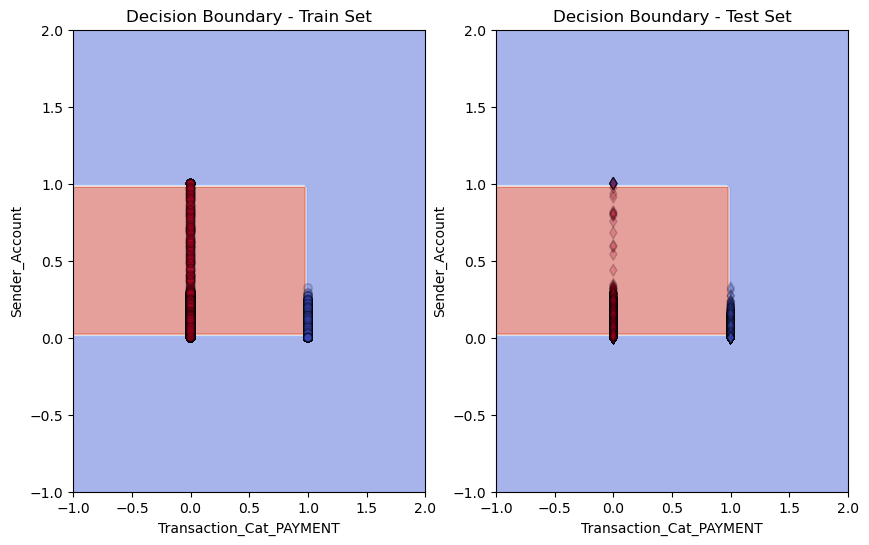

In [71]:
feature_importance = pd.Series(model.feature_importances_, index = selected_feature_names).sort_values(ascending=False)
features = feature_importance[:2].index #get the first two most important features
X_train_cols = X_train[features] 
clf = model
clf.fit(X_train_cols,y_train)
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))
# Plotting the tree boundaries on ax0
disp = DecisionBoundaryDisplay.from_estimator(clf, 
                                              X_train_cols, 
                                              response_method="predict",
                                              xlabel=features[0], ylabel=features[1],
                                              alpha=0.5, 
                                              ax = ax0,
                                              cmap=plt.cm.coolwarm)

# Plotting the training pointson ax0   
disp.ax_.scatter(X_train[features[0]], X_train[features[1]], 
                 c=y_train, edgecolor="k", alpha=0.2,
                 cmap=plt.cm.coolwarm)

# Plotting the tree boundaries on ax1
disp1 = DecisionBoundaryDisplay.from_estimator(clf, 
                                              X_test[features], 
                                              response_method="predict",
                                              xlabel=features[0], ylabel=features[1],
                                              alpha=0.5, 
                                              ax = ax1,
                                              cmap=plt.cm.coolwarm)
# Plot the testing points on ax1
disp1.ax_.scatter(X_test[features[0]], X_test[features[1]], 
                 c=y_test, edgecolor="k", alpha=0.2,
                 cmap=plt.cm.coolwarm, marker = 'd')

ax0.set_title("Decision Boundary - Train Set")
ax1.set_title("Decision Boundary - Test Set")

plt.savefig('images/decision_boundary.png')

##### Questions